In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from itertools import permutations, combinations

from datasets import Data_From_File
from sklearn.metrics import ndcg_score
from perms import Gk

import matplotlib.pyplot as plt


In [12]:
class Data_for_torch(Dataset, Data_From_File):
    
    def __init__(self, file, which = 0):
        
        self.data = pd.DataFrame(Data_From_File.open_file(file)[which]).drop('doc_id', axis = 1)
        self.dict_data = self.data.set_index('query_id').T.to_dict('list')
        self.keys = list(self.dict_data.keys())
        
    def __len__(self):
        return len(self.dict_data)
        
    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.dict_data[key]

In [13]:
train_data = Data_for_torch('datas_full_10k_1.pkl', which = 0)
vali_data = Data_for_torch('datas_full_10k_1.pkl', which = -1)

In [14]:
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(vali_data, batch_size=1)

In [15]:
class ListNet(nn.Module):
    def __init__(self,inp_size = 136, out_size = 1 ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inp_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.LeakyReLU(),
            nn.Linear(512,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,64),
            nn.LeakyReLU(),
            nn.Linear(64,32),
            nn.LeakyReLU(),
            nn.Linear(32,out_size),
            
            )
        
        # self.razdel = torch.tensor(['_' for i in range(inp_size)])
        
    def forward(self, X):
        output = self.model(X).squeeze()
        return output

In [16]:
def loss(p,y):
    return -torch.mean(y * torch.log_softmax(p, dim = -1))

def vali(vali_loader, model, k = [5,10,None]):
    model.eval()
    
    device = next(model.parameters()).device
    acc = np.zeros(3)
    length = len(vali_loader)
    
    for batch in vali_loader:
        X = batch[0].to(device)
        y = batch[1].cpu().view(-1).numpy()
            
        preds = model(X.float()).view(-1).detach().cpu().numpy()
        for j,i in enumerate(k):
            try:
                acc[j] += ndcg_score([list(y)], [list(preds)], k = i)
            except:
                length -= 1

            
    return acc / length

def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, sheluder, epochs, is_test = True, is_sheluder = False ):
    device = next(model.parameters()).device
    
    pred_probs = nn.Softmax(dim = -1)
    y_probs = nn.Softmax(dim = -1)
    
    train_loss = []
    metric = []
    
    
    
    for i in range(epochs):
        loss_epoch = 0
        
        model.train()
        for batch in train_dataloader:
            X = batch[0].float().to(device)
            y = batch[1].squeeze().float().to(device)
            
            preds = model(X).squeeze()
            
            probas_p = preds
            probas_y = y
            
            optimizer.zero_grad()            
            loss_ = loss_fn(probas_p, probas_y)
            loss_.backward()
            optimizer.step()

            loss_epoch += loss_
          
        
        train_loss.append(loss_epoch.clone().detach().cpu().numpy()/len(train_dataloader))
        
        if is_test:
            model.eval()
            metric.append(vali(vali_loader=test_dataloader, model = model))
            print(f'loss for epoch {i+1} is {train_loss[i]:.4f} ||for epoch{i+1} ndcg@5_score is {metric[i][0]:.4f} || ndcg@10_score is {metric[i][1]:.4f} || ndcg_score is {metric[i][2]:.4f}  ')
        else:    
            print(f'loss for epoch {i+1} is {train_loss[i]:.4f}')
            
        if is_sheluder:   
            sheluder.step(loss_epoch)
            
    return np.array(train_loss), np.array(metric)
    
        
def plot_loss_and_metric(train_loss, name, is_metric = True, metric = []):
    size = len(train_loss)
    
    if is_metric:
        fig, ax = plt.subplots(1,4, figsize = (20,6), constrained_layout=True)
        
        
        ax[0].set_yscale('log')
        ax[0].plot(np.arange(size), train_loss)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('loss')
        ax[0].set_title('train loss')
        ax[0].grid(True)
        
        for i,j  in enumerate([5,10,'']):
        
            ax[i+1].plot(np.arange(size), metric[:,i])
            ax[i+1].set_xlabel('epochs')
            ax[i+1].set_ylabel(f'ndcg@{j}_score')
            ax[i+1].set_title('eval metric')
            ax[i+1].grid(True)

        
        fig.savefig(name)
        plt.show()
        
    else:
        fig, ax = plt.subplots(figsize = (6,6))
        fig.set_figheight(8)
        fig.set_figwidth(12)
        
        ax.set_yscale('log')
        ax.plot(np.arange(size), train_loss)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.set_title('train loss')
        ax.grid(True)
                
        fig.savefig(name)

        plt.show()
        
            

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ListNet().to(device)

kl_loss = nn.KLDivLoss()

opt_adam = torch.optim.AdamW(model.parameters(), lr=0.0001)

m_loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, mode='min', patience=3, factor=0.1, verbose=True)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

model


Number of trainable parameters: 624577


ListNet(
  (model): Sequential(
    (0): Linear(in_features=136, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=64, out_features=64, bias=True)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): LeakyReLU(negative_slope=0.01)
    (18): Linear(in_features=32, out_features=1

In [19]:
losses = train(train_dataloader=train_loader,
               test_dataloader= test_loader,
      model = model,
      loss_fn=loss,
      optimizer=opt_adam,sheluder=scheduler,
      epochs=300)

loss for epoch 1 is 6.8560 ||for epoch1 ndcg@5_score is 0.2533 || ndcg@10_score is 0.2792 || ndcg_score is 0.6469  
loss for epoch 2 is 4.8654 ||for epoch2 ndcg@5_score is 0.3435 || ndcg@10_score is 0.3622 || ndcg_score is 0.6771  
loss for epoch 3 is 3.3683 ||for epoch3 ndcg@5_score is 0.4047 || ndcg@10_score is 0.4167 || ndcg_score is 0.7035  
loss for epoch 4 is 3.2285 ||for epoch4 ndcg@5_score is 0.3818 || ndcg@10_score is 0.4018 || ndcg_score is 0.7013  
loss for epoch 5 is 3.0684 ||for epoch5 ndcg@5_score is 0.4207 || ndcg@10_score is 0.4340 || ndcg_score is 0.7133  
loss for epoch 6 is 3.5688 ||for epoch6 ndcg@5_score is 0.4135 || ndcg@10_score is 0.4312 || ndcg_score is 0.7163  
loss for epoch 7 is 2.9403 ||for epoch7 ndcg@5_score is 0.4369 || ndcg@10_score is 0.4503 || ndcg_score is 0.7201  
loss for epoch 8 is 2.9869 ||for epoch8 ndcg@5_score is 0.4474 || ndcg@10_score is 0.4588 || ndcg_score is 0.7237  
loss for epoch 9 is 3.2506 ||for epoch9 ndcg@5_score is 0.4618 || ndcg@1

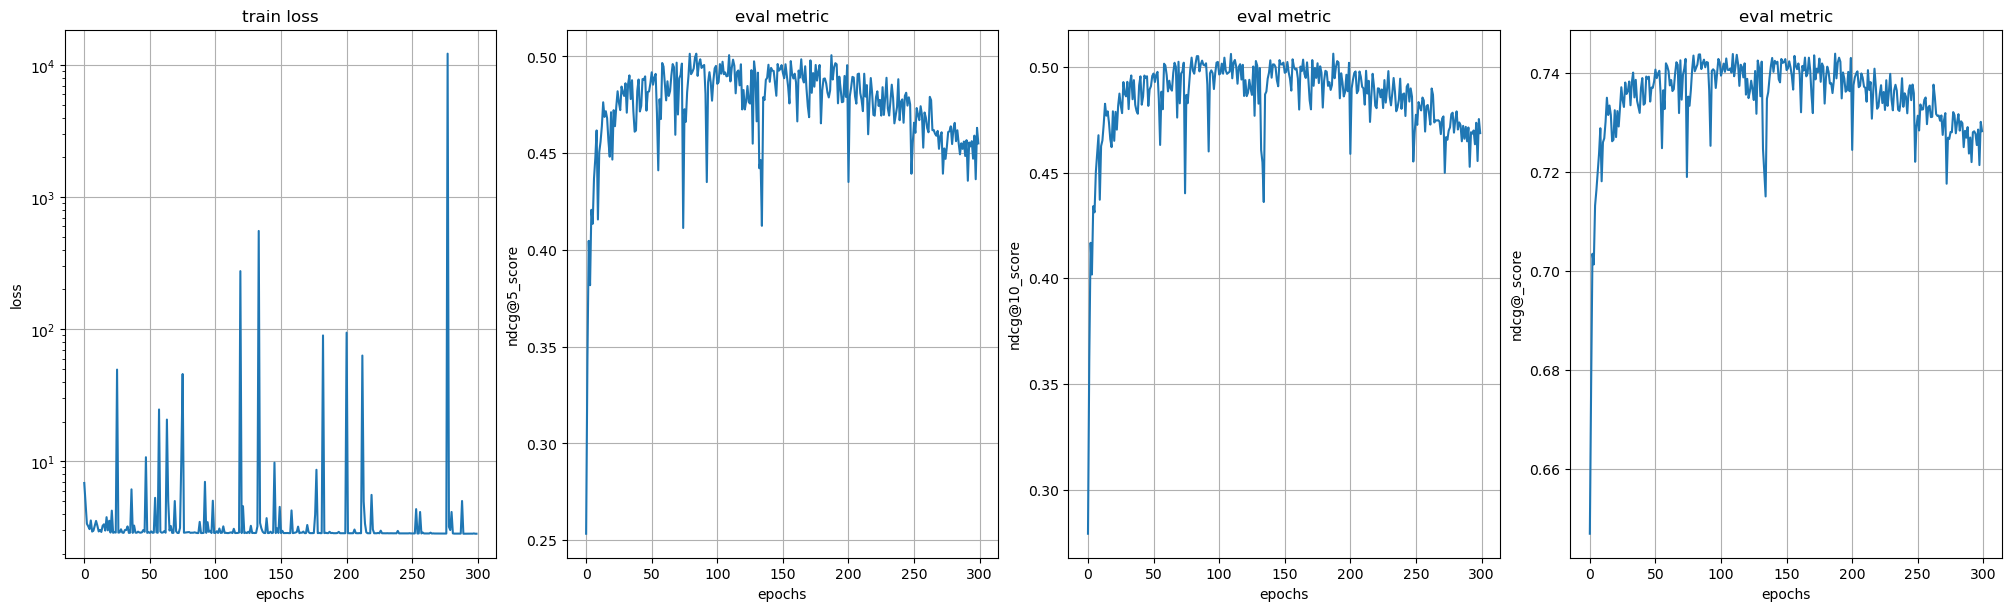

In [20]:
plot_loss_and_metric(train_loss=losses[0], metric = losses[1],  name = 'loss and metric for lin_model_2(leakyrelu)_crosentr_from_tabnet')



In [21]:
name = 'lin_model_2(leakyrelu)_crosentr_from_tabnet '
torch.save(model, name)

In [22]:
torch.load('lin_model_2(leakyrelu)_crosentr_from_tabnet ', weights_only=False)

ListNet(
  (model): Sequential(
    (0): Linear(in_features=136, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=64, out_features=64, bias=True)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): LeakyReLU(negative_slope=0.01)
    (18): Linear(in_features=32, out_features=1

In [23]:
a = np.zeros((3,3,2))

a[:,:,0] = np.array([[1,0,1],[0,2,0],[3,0,0]])
a[:,:,1] = np.array([[0,0,1],[0,1,0],[1,0,0]])


In [24]:
b = np.transpose(a, [2,0,1])

b = np.reshape(b, [2,9])

In [25]:
b

array([[1., 0., 1., 0., 2., 0., 3., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0.]])